Загрузим данные:

In [14]:
import json

In [15]:
with open('processed_data.json', 'r', encoding='utf-8') as inp:
    data = json.load(inp)

In [16]:
'}' in set([j for i in data for j in i])

False

In [17]:
from collections import Counter

In [18]:
from collections import defaultdict

Языковая модель:

Будем кодировать тильдами начало чанка, а символом '}' - конец чанка

In [20]:
import math

In [69]:
class CharLM:
    def __init__(self, data_pack, order=4):
        self.order = order
        self.ngrams = defaultdict(Counter)
        #число слов в модели:
        self.N = 0
        #проходимся отдельно по каждому батчу:
        for data in data_pack:
            #обновляем число слов в модели:
            self.N += len(data)
            pad = '~' * order  # специальный символ для начала предложения (для первого символа будет ~~)
            data = pad + data
            # Для каждой n-граммы из символов посчитаем символы, которые идут после ней
            # Например, если порядок модели 2, а корпус выглядит так 'abcbcb':
            # self.ngrams['~~']['a'] == 1
            # self.ngrams['~a']['b'] == 1
            # self.ngrams['ab']['c'] == 1
            # self.ngrams['bc']['b'] == 2
            # self.ngrams['cb']['c'] == 1
            ##
            for i in range(len(data)-order):
                self.ngrams[data[i:i+order]][data[i+order]] += 1
        self.prior_probabilities = dict()
        # считаем приорные вероятности n-грамм (они нужны для вычисления функции ошидки);
        for ngram in self.ngrams.keys():
            self.prior_probabilities[ngram] = sum(self.ngrams[ngram].values())/self.N
        self.lm = {history: self.normalize(chars) for history, chars in self.ngrams.items()}
    
    def normalize(self, counter):
        # Всё как обычно - превращаем частоты в вероятности
        # сделаем только в одну строчку - more pythonic ;)
        n = sum(counter.values())
        return {key: value/n for key, value in counter.items()}
    
    def loss(self):
        if not hasattr(self, '_loss'):
            self._loss = sum([self.prior_probabilities[ngram] * (1 - max(self.lm[ngram].values())) for ngram in self.ngrams.keys()])
        return self._loss
    
    def __getitem__(self, history):
        return self.lm[history]
    
    def continue_sequence(self, prior_seq, length):
        output_seq = ''
        for i in range(length):
            prior_seq = prior_seq[-self.order:]
            new_token = sorted(self.lm[prior_seq], key = lambda x: - self.lm[prior_seq][x])[0]
            prior_seq += new_token
            output_seq += new_token
            if new_token == '}':
                ##закрывающая фигурная скобка - конец параграфа
                break
        return output_seq
   
    def generate_sequence(self, length):
        return self.continue_sequence('~' * self.order, length)
    
    def continue_to_paragraph(self, prior_seq):
        new_token = ''
        output_seq = ''
        while new_token != '}':
            print(new_token, end = '')
            prior_seq = prior_seq[-self.order:]
            new_token = sorted(self.lm[prior_seq], key = lambda x: - self.lm[prior_seq][x])[0]
            prior_seq += new_token
            output_seq += new_token
        return output_seq
    
    def generate_paragraph(self):
        return self.continue_to_paragraph('~' * self.order)
    
    def pps(self, data):
        log_probs = []
        '''returns model log-probability per one symb for data'''
        for chunk in data:
            seq = '~'*self.order + chunk
            for i in range(len(seq)-self.order):
                log_probs.append(math.log(self.lm[seq[i:i+self.order]][seq[i+self.order]], 2))
        return sum(log_probs)/len(log_probs)

Построим 4-граммную модель на базе коллекции:

Для начала разобьём все тексты на абзацы:

In [51]:
import re

In [52]:
splitted_data = []
for text in data:
    splitted_data += re.split('\n{2,}', text)

In [53]:
splitted_data = [i for i in splitted_data if i]

In [7]:
del(data)

Теперь обучим нашу модельку:

In [54]:
lm1 = CharLM(splitted_data)

Посмотрим на функцию ошибки:

In [55]:
lm1.loss()

0.37274359850169

In [56]:
lm1.pps(splitted_data)

-1.6369797378032738

Сгенерируем последовательность символов:

In [57]:
lm1.generate_sequence(30)

'The statue of the statue of th'

(Статуя статуи статуи, ничего интересного)

Будем менять порядок модели, смотреть как меняется ошибка и какая последовательность получается:

In [58]:
for i in range(5, 21):
    lm = CharLM(splitted_data, order = i)
    print(i, round(lm.loss(),8), lm.pps(splitted_data), lm.generate_sequence(100), end='\n\n')

5 0.30059197 -1.2663047014346862 The statue of the statue of the statue of the statue of the statue of the statue of the statue of th

6 0.24404407 -0.9840994150197638 The secret door is a small steel shield); Atk +1 melee (1d4+1, 19–20/x2, longsword), or +5 ranged (1

7 0.19736376 -0.7590732466613155 The secret door is a small steel shield); Atk +1 melee (1d4+1, 19–20/x2, longsword), or +5 ranged (1

8 0.15652276 -0.5753131203123721 The secret door is locked (DC 25) is trapped with a successful Search +6, Spot +3, Swim +10, Wildern

9 0.12300304 -0.43575977683890044 The secret door in the centre of the stairs and will attack anyone who is not likely to be able to s

10 0.09687138 -0.33421634938494316 The secret door in the center of the room is a similar check (DC 15) to notice that the characters a

11 0.07678214 -0.2597776776095335 The secret door in the center of the room is a similar check (DC 15) to notice that the party and th

12 0.0613234 -0.20530441800722574 The secret door i

Видим, что ошибка снижается, а текст становится всё более и более осмысленным. Попробуем породить абзац при помощи модели порядка 20:

In [70]:
fav_lm = CharLM(splitted_data, 20)

In [71]:
fav_lm.generate_paragraph()

KeyError: 'search is conducted.'

Породим текст при помощи модели порядка 20:

In [63]:
fav_lm = CharLM(splitted_data, 20)
fav_lm.generate_sequence(180)

'The secret door to the complex of rooms below. The door is very well made. so that casual observation cannot find it. The standard chances to locate secret doors apply ifa search i'

Построим график того, как меняется качество модели при увеличении порядка от 2 до 100:

In [64]:
orders = range(2,101)
losses = []
for order in orders:
    losses.append(CharLM(splitted_data, order).loss())

In [66]:
import matplotlib.pyplot as plt

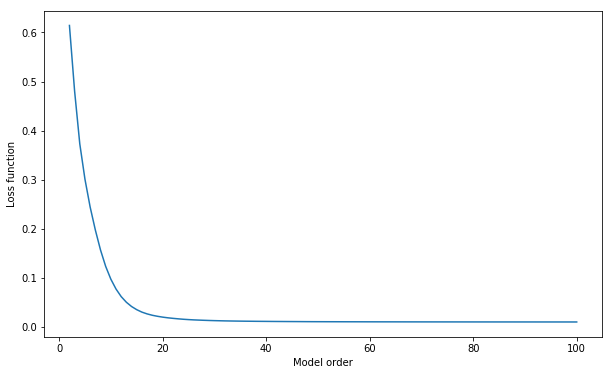

In [73]:
plt.figure(figsize=(10, 6))
plt.xlabel("Model order")
plt.ylabel("Loss function")
plt.plot(orders, losses)
plt.savefig("Markoff_loss.png")

Попробуем использовать модифицированную при помощи логистической регрессии модель:

In [74]:
from sklearn.linear_model import LogisticRegression

Напишем функцию для генерации датасета для регрессии на основе предсказаний моделей различного порядка:

Для начала будем считать одинаково вероятными все символы после неизвестной нам последовательности, модифицируем наш класс:

In [81]:
import random

In [48]:
df = pd.DataFrame(data=np.ones((4,3)),index=['a','b','c','d'], columns=['a','b','c'])

In [49]:
df['a']['d'] += 1

In [66]:
df.loc['d']

a    2.0
b    1.0
c    1.0
Name: d, dtype: float64

In [5]:
import numpy as np

In [23]:
type(a/np.int64(3))

numpy.float64

In [21]:
class UnbiasedCharLM:
    
    ##переписать с pandas.DataFrame вместо defaultdict'а counter'ов
    def __init__(self, data_pack, order=4):
        self.order = order
        self.alphabet = list(set(''.join(data_pack)))
        data_pack = ['~' * self.order + text for text in data_pack]
        columns = [i[j:j+order] for i in data_pack for j in range(len(i)-order)]
        self.ngrams = pd.DataFrame(data=np.ones(shape=(len(self.alphabet), len(columns)),
                                                   dtype=np.int64), index=self.alphabet, columns=columns)
        #проходимся отдельно по каждому батчу:
        for data in data_pack:
            #обновляем число слов в модели:
            for i in range(len(data)-order):
                print(data[i+order] in self.ngrams[data[i:i+order]].index)
                self.ngrams[data[i:i+order]][data[i+order]] += 1
        self.prior_probabilities = pd.Series(index=self.ngrams.index)
        # считаем приорные вероятности n-грамм (они нужны для вычисления функции ошидки);
        for ngrams in self.ngrams:
            self.prior_probabilities[ngram] = self.ngrams[ngram].sum()/self.ngrams.sum()
        self.lm = self.ngrams.div(self.ngrams.sum(axis=0), axis=1)
    
    generate_sequence = CharLM.generate_sequence
    
    def continue_sequence(self, prior_seq, length):
        output_seq = ''
        for i in range(length):
            prior_seq = prior_seq[-self.order:]
            if prior_seq in self.lm:
                new_token = self.lm[prior_seq].argmax()
            else:
                for token in self.alphabet:
                    if prior_seq + token in self.lm:
                        new_token = token
                        break
                    if token == self.alphabet[-1]:
                        raise Exception(f"Cannot continue after symbol {i}: {output_seq}")
            prior_seq += new_token
            output_seq += new_token
        return output_seq
    
    def loss(self):
        if not hasattr(self, '_loss'):
            self._loss = sum([self.prior_probabilities[ngram] * (1 - self.lm[ngram].max()) for ngram in self.ngrams])
        return self._loss
                                       

C этой реализацией pandas всё время выдаёт KeyError, хотя не должен, поэтому не будем больше с ней возиться!

<b> Векторные методы: </b>

In [6]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [7]:
class Encoder:
    def __init__(self, data):
        all_data = [j for i in data for j in i]
        self.le = LabelEncoder().fit(all_data)
        self.ohe = OneHotEncoder(sparse=False, dtype=np.bool).fit(self.le.transform(all_data).reshape(-1,1))
    
    def encode(self, data):
        encoded = [self.transform(i) for i in data]
        return encoded
    
    def transform(self, seq):
        return self.ohe.transform(self.le.transform(list(seq)).reshape(-1,1))
    
    def inverse_transform(self, seq):
        return self.le.inverse_transform(seq.dot(self.ohe.active_features_).astype(int))
    
    def inverse_label(self, seq):
        return seq.dot(self.ohe.active_features_).astype(int)

In [39]:
enc = Encoder(splitted_data)

In [40]:
encoded = enc.encode(splitted_data)

In [41]:
print(encoded[0])

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


In [42]:
enc.inverse_label(encoded[0])

array([38,  5, 44, 77, 84, 90, 81, 78, 88, 77,  5, 56, 90, 85, 87, 78, 88,
       74])

In [43]:
del(X, y, encoder)

NameError: name 'X' is not defined

Отлично, так держать!

Теперь напишем функцию, которая генерирует из данных n-граммный датасет, пригодный для моделек машинного обучения:

In [88]:
def get_data_set(data, order):
    if type(data[0]) == str:
        data = ['~'*order + text for text in data]
    else:
        data = [['~']*order + text for text in data]
    encoder = Encoder(data)
    encoded = encoder.encode(data)
    X, y = [], []
    for chunk in encoded:
        for i in range(chunk.shape[0] - order):
            X.append(np.hstack(chunk[i:i+order]))
            y.append(chunk[i+order])
    return np.array(X), np.array(y), encoder 

In [9]:
X, y, encoder = get_data_set(splitted_data, 20)

In [20]:
X.shape

(1841483, 2800)

Используя 20-граммы, у нас получилось 1841483 объектов с 2800 признаками.

Теперь попробуем применить какую-нибудь модельку машинного обучения - например, решающее дерево:

In [12]:
from sklearn.linear_model import LogisticRegression

Перведём y из one-hot векторов в числа:

In [10]:
y = encoder.inverse_label(y)

In [21]:
from sklearn.model_selection import train_test_split

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

NameError: name 'X' is not defined

In [24]:
from sklearn.tree import DecisionTreeClassifier

In [25]:
from math import log

In [26]:
log(2800, 2)

11.451211111832329

In [27]:
clf = DecisionTreeClassifier(random_state=42, max_depth=log(2800, 2))

In [28]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini',
            max_depth=11.451211111832329, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best')

Посмотрим на качество на обучающей выборке:

In [35]:
clf.score(X_train, y_train)

0.2971712970002389

Короч, мы использовали в качестве обучающей только 20% выборки, отсюда такое плохое качество

Попытка посмотреть качество на тестовой выборке вызывает MemoryError, тк тестовая выборка получилась больше, лол

In [80]:
def generate_text(length, model, N, encoder):
    ## длина алфавита:
    outp_text = ''
    alph_length = encoder.ohe.active_features_.shape[0]
    start_token = np.hstack([encoder.transform('~') for i in range(length)])
    for i in range(length):
        prediction = model.predict(start_token)
        outp_text += encoder.le.inverse_transform(prediction)[0]
        a = start_token[0][:-alph_length].reshape(1,-1)
        b = encoder.ohe.transform(prediction.reshape(-1, 1))
        start_token = np.hstack([a, b])
    return outp_text

In [81]:
generate_text(20, clf, 20, encoder)

c:\program files\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\program files\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\program files\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\program files\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

' t t t t t t t t t t'

Попробуем использовать пословное представление:

In [82]:
from nltk.tokenize import word_tokenize

In [86]:
data_tokenized = [word_tokenize(i) for i in splitted_data]

In [90]:
X, y, encoder = get_data_set(data_tokenized, 4)

MemoryError: 

In [89]:
['1','2','3'] + ['4', '5', '6']

['1', '2', '3', '4', '5', '6']